# Ensemble learning



In [95]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

train=pd.read_csv("train.csv")

#separating categorical and numerical features
categorical_features=[feature for feature in train.columns if train[feature].dtype=='object']
numerical_features=[feature for feature in train.columns if feature not in categorical_features]

# EDA

<Axes: xlabel='SalePrice', ylabel='Density'>

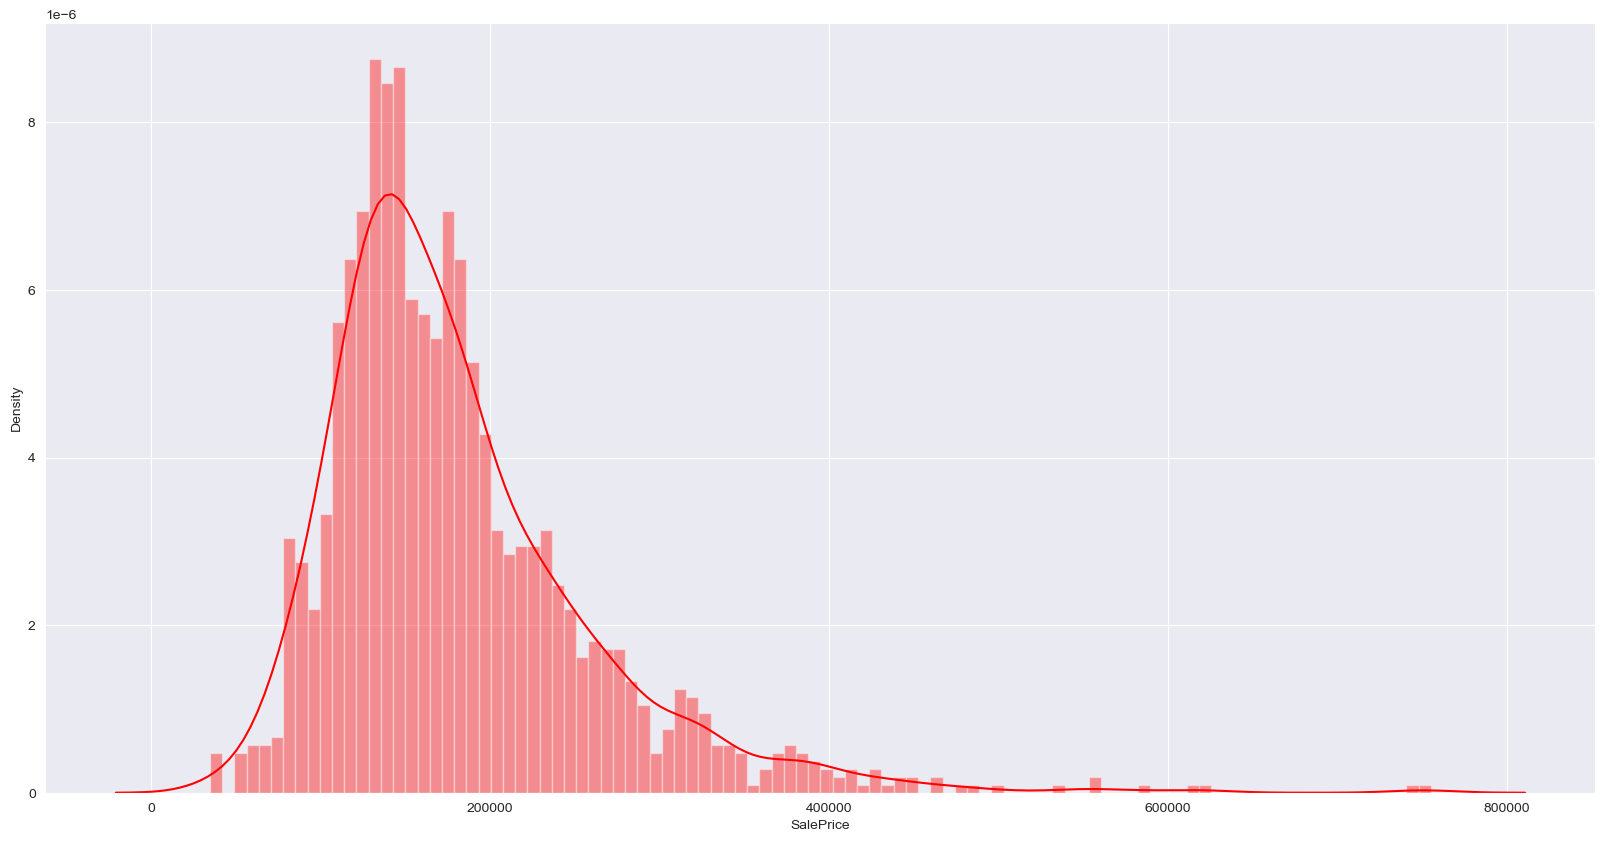

In [96]:
#distribution of saleprice
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.distplot(train['SalePrice'], color='red', bins=100, hist_kws={'alpha': 0.4})

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

<Figure size 2000x2500 with 0 Axes>

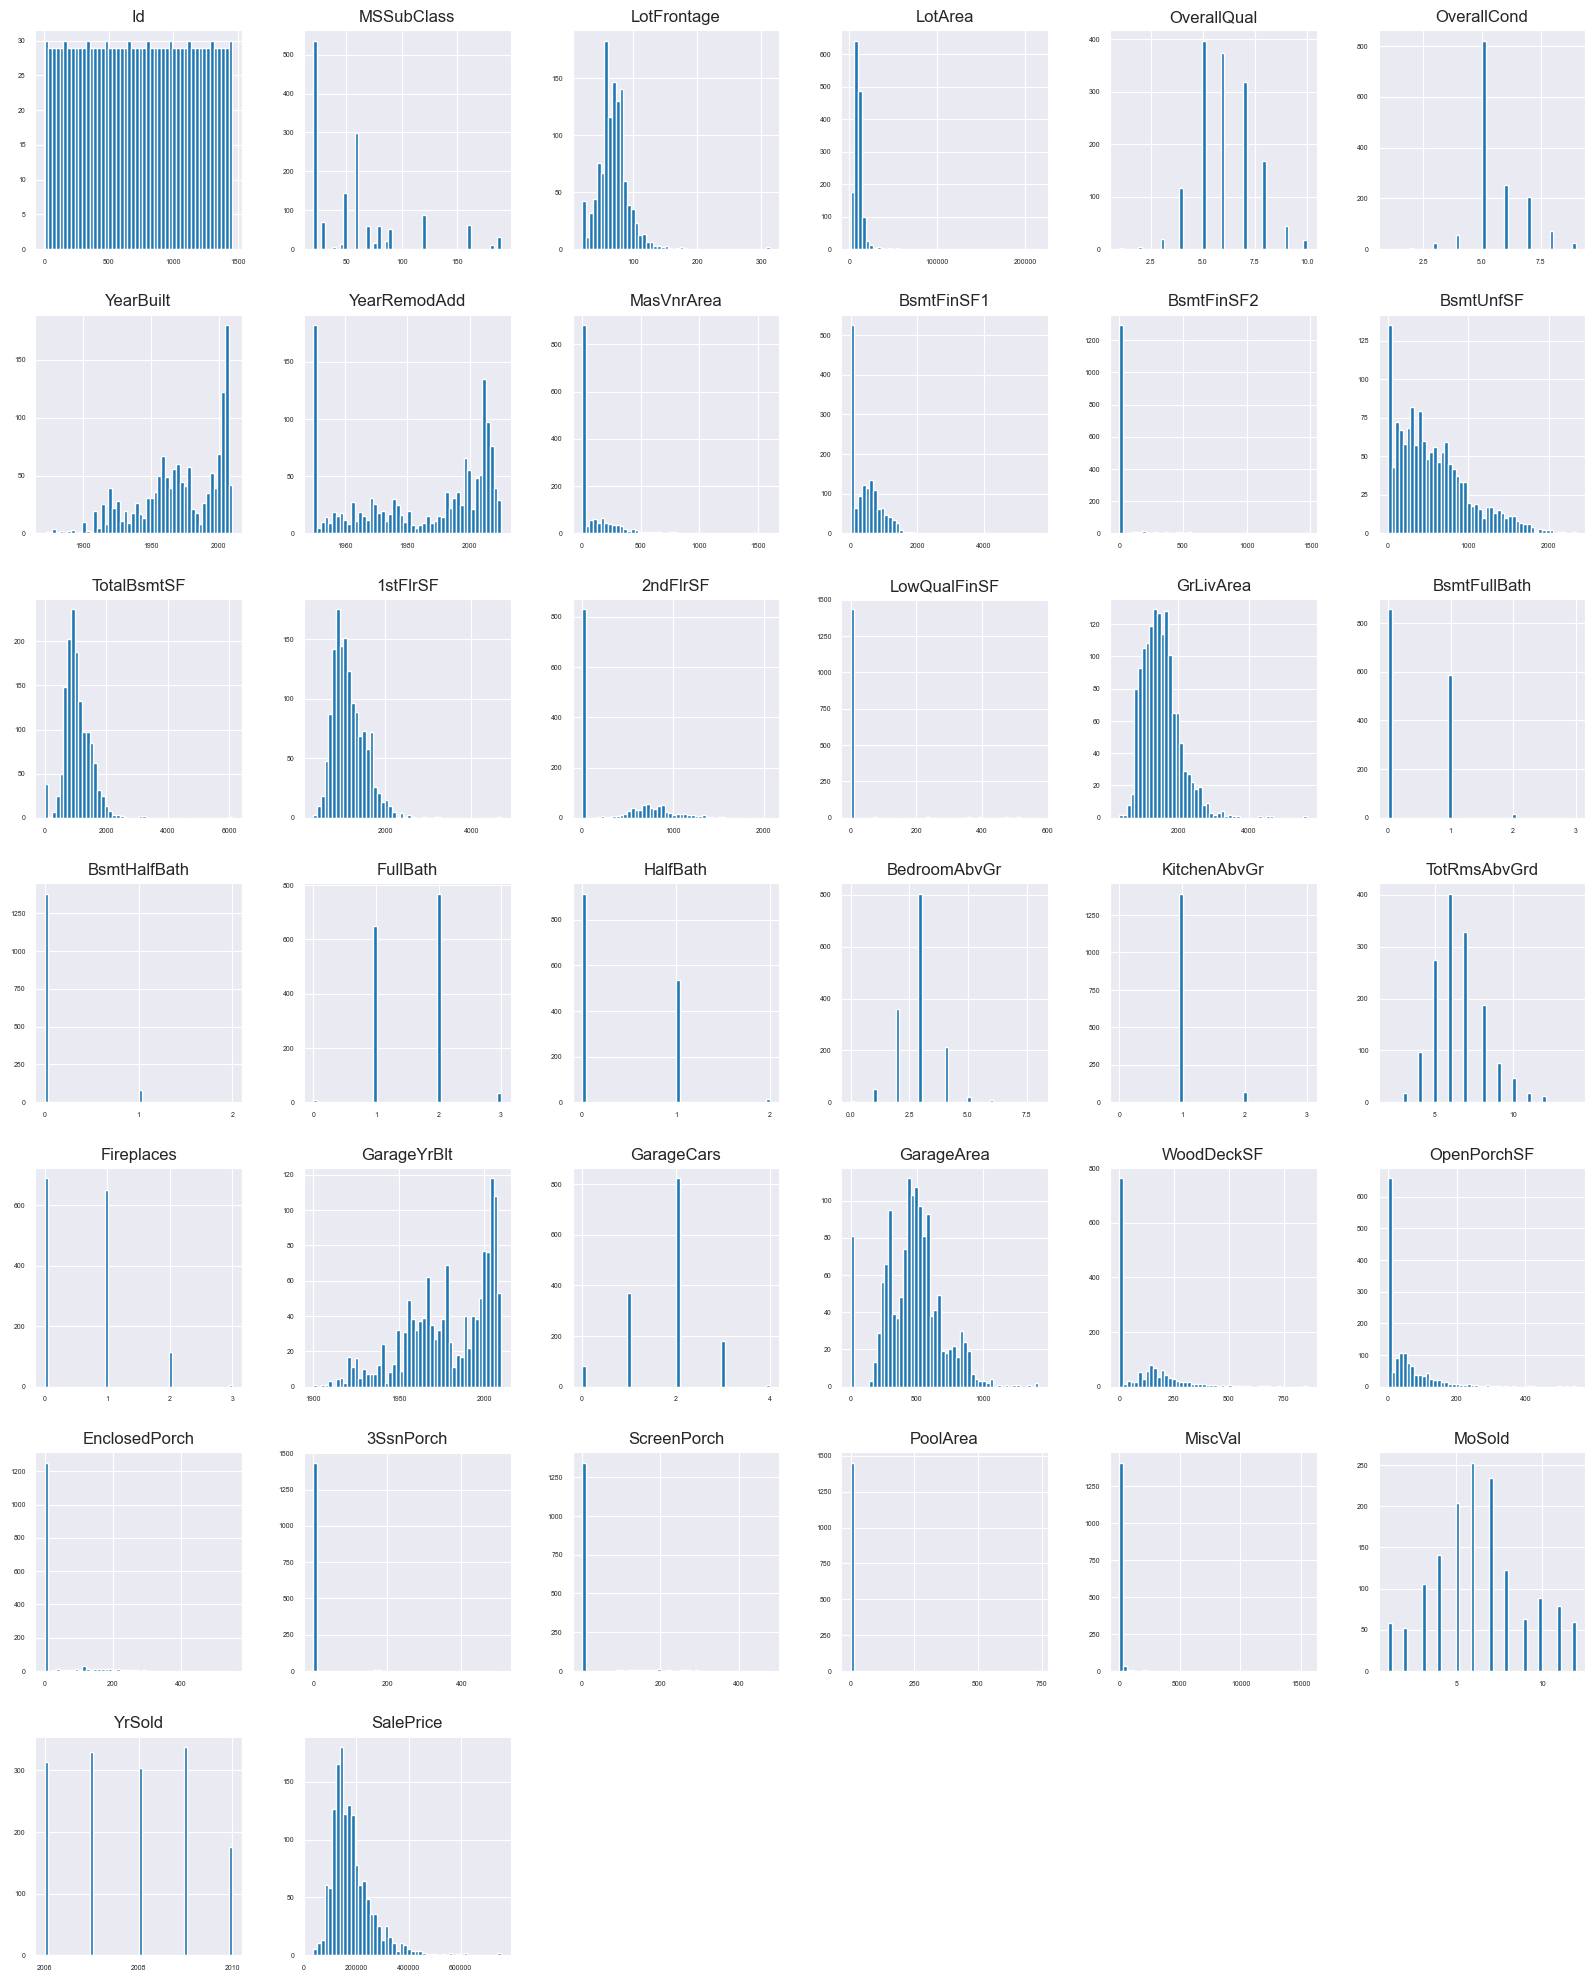

In [97]:
train_num=train[numerical_features]
plt.figure(figsize=(20,25))
train_num.hist(figsize=(20,25),bins=50, xlabelsize=5, ylabelsize=5)

<Axes: >

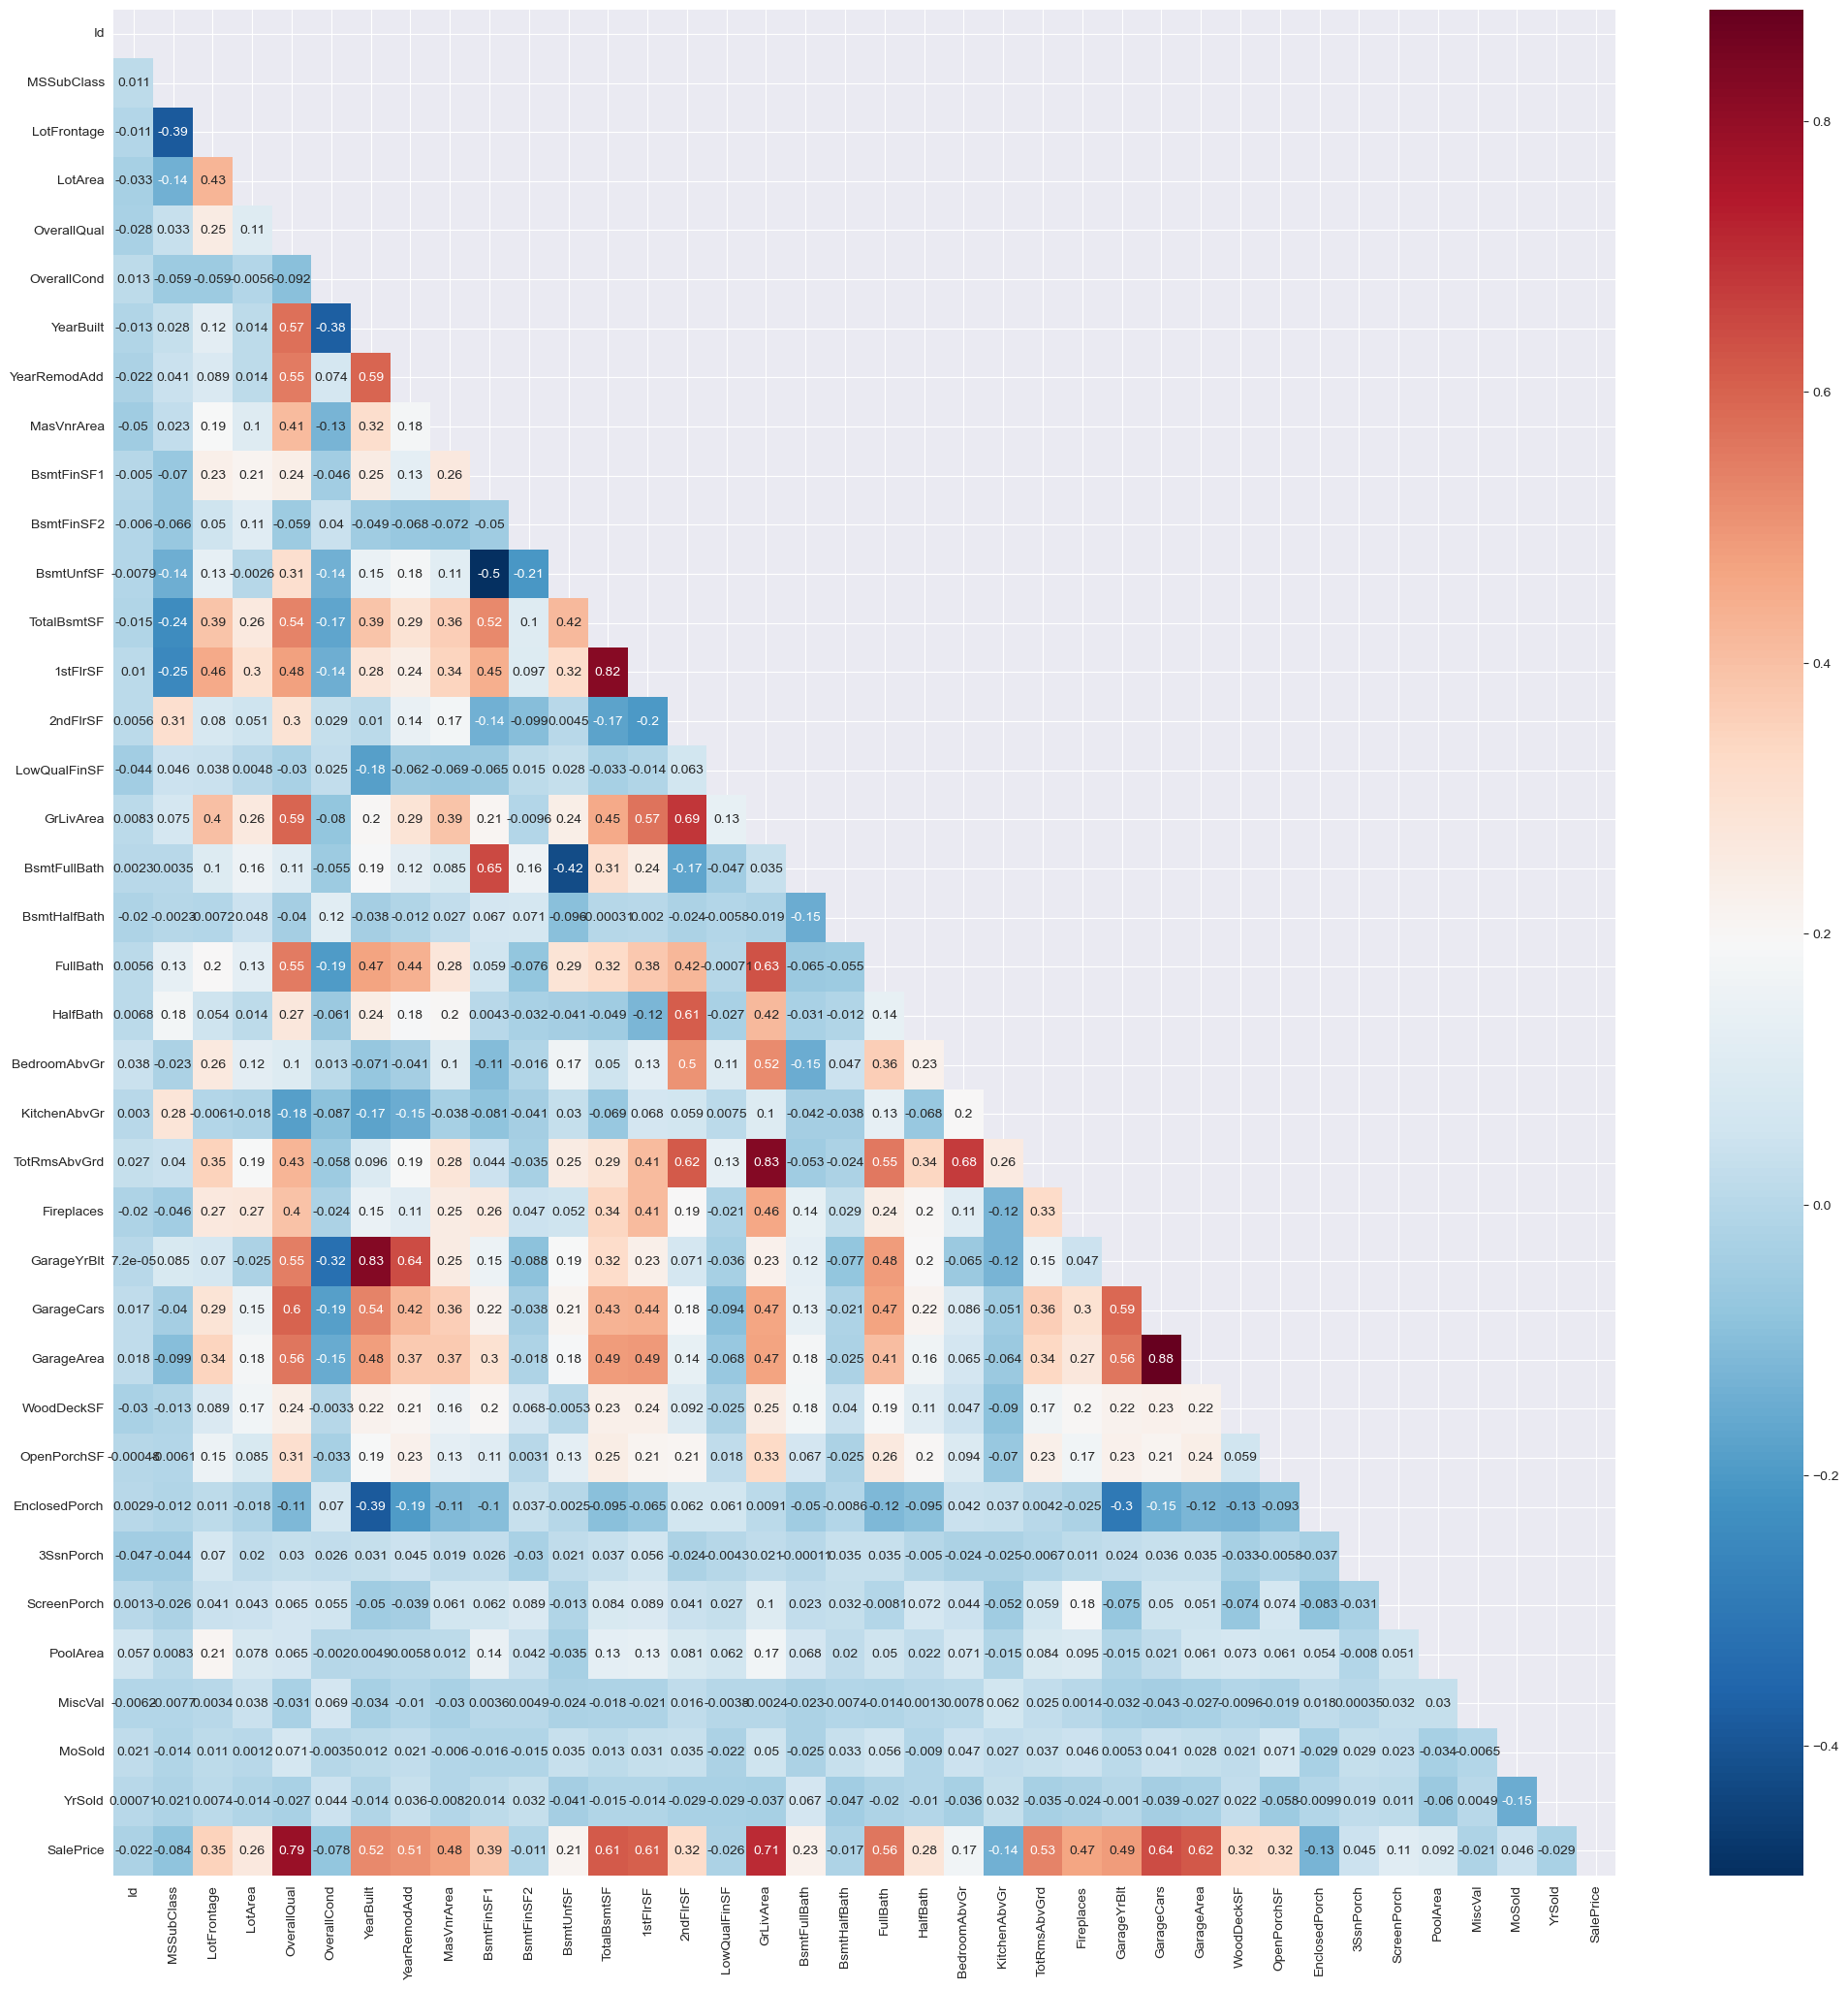

In [98]:
#correlation heatmap
plt.figure(figsize=(25,25))
corr=train_num.corr()
msk = np.triu(np.ones_like(corr))
sns.heatmap(corr,cmap=plt.cm.RdBu_r,annot=True,annot_kws={'size':10},mask=msk)

- Key takeaways froom the heatmap
- Garage Area and Garage Cars has a correlation coefficient of 0.88.To avoid nulticollinearity we will keep only one of them and that would be Garage Cars , the reason being it has slightly high correlation coefficient with Sale Price to that of Garage Area.
- 1stFlrSF and TotalBsmtSF has a correlation coefficient of 0.82 again for same reason we will only keep 1stFlrSF
- TotRmsAbvGr and GrLivArea has a correlation cofficient of 0.83, and again for same reason we will only keep GrLivArea
- GarageYrBlt and YearBuilt has a correlation of 0.83 and therefore we will only keep YearBuilt

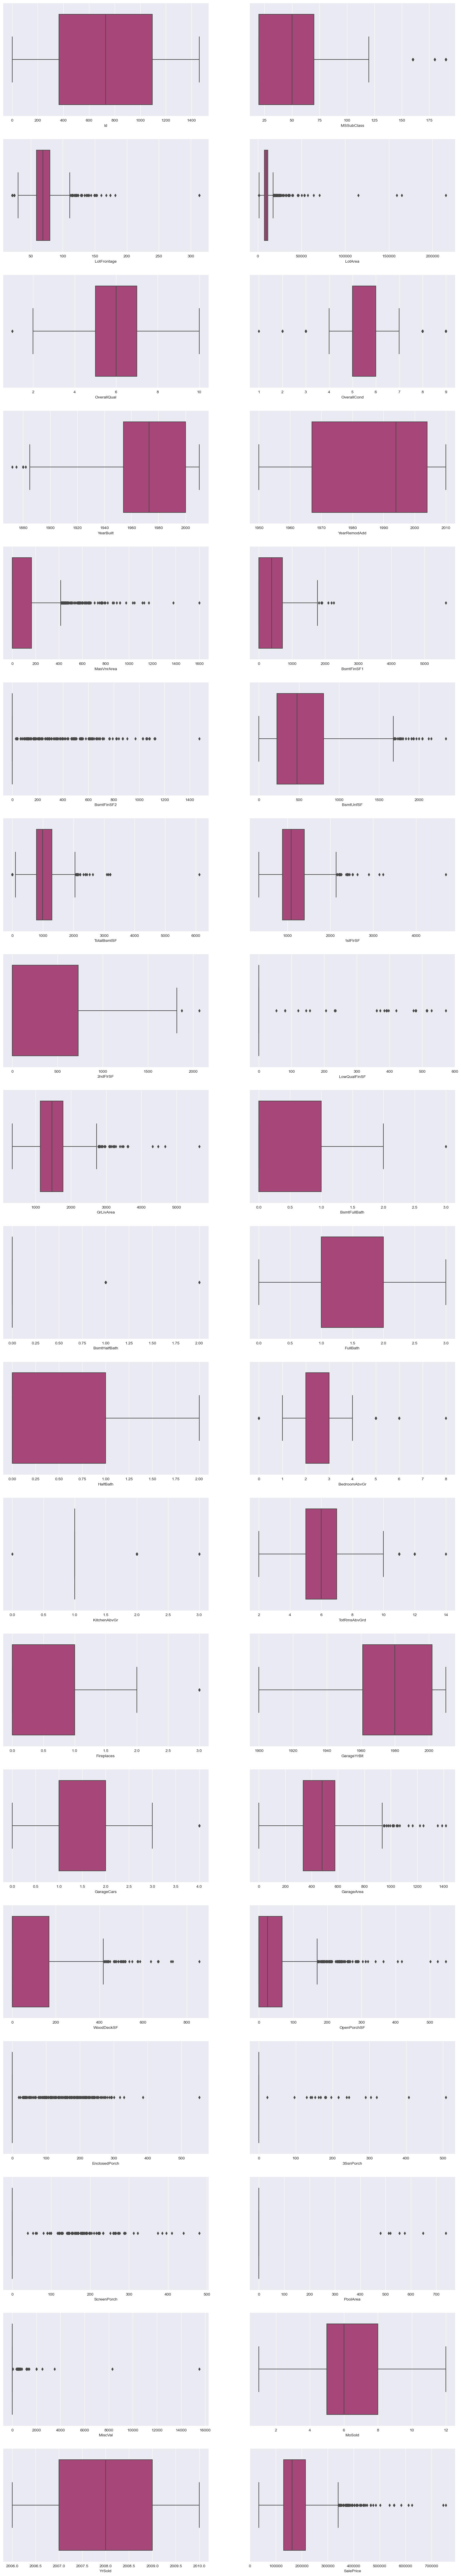

In [99]:
#visualization of numerical features using box plot to determine/remove extreme outliers
n_row=19
n_col=2

fig,ax=plt.subplots(nrows=19,ncols=2,figsize=(20,6*n_row))
i=0  #for row number
for feature in numerical_features:
    n=i//n_col   #for row no.
    m=i%n_col    #for col no.
    sns.boxplot(x=feature,data=train,palette='magma',ax=ax[n,m])
    i+=1

- Observations from the above sets of boxplots
- Some of the features like LotFrontage,BsmtFinSF1,TotalBsmtSF and MScVal has some extreme outliers. And we will look at them more rigorously in the data preprocessing part

In [100]:
#for determining no. of unique categories for each feature
dict_={}
for feature in categorical_features:
    dict_[feature]=train[feature].value_counts().shape[0]
pd.DataFrame(dict_,index=['unique_counts']).transpose()

,unique_counts
MSZoning,5
Street,2
Alley,2
LotShape,4
LandContour,4
Utilities,2
LotConfig,5
LandSlope,3
Neighborhood,25
Condition1,9


<Axes: xlabel='Exterior2nd', ylabel='count'>

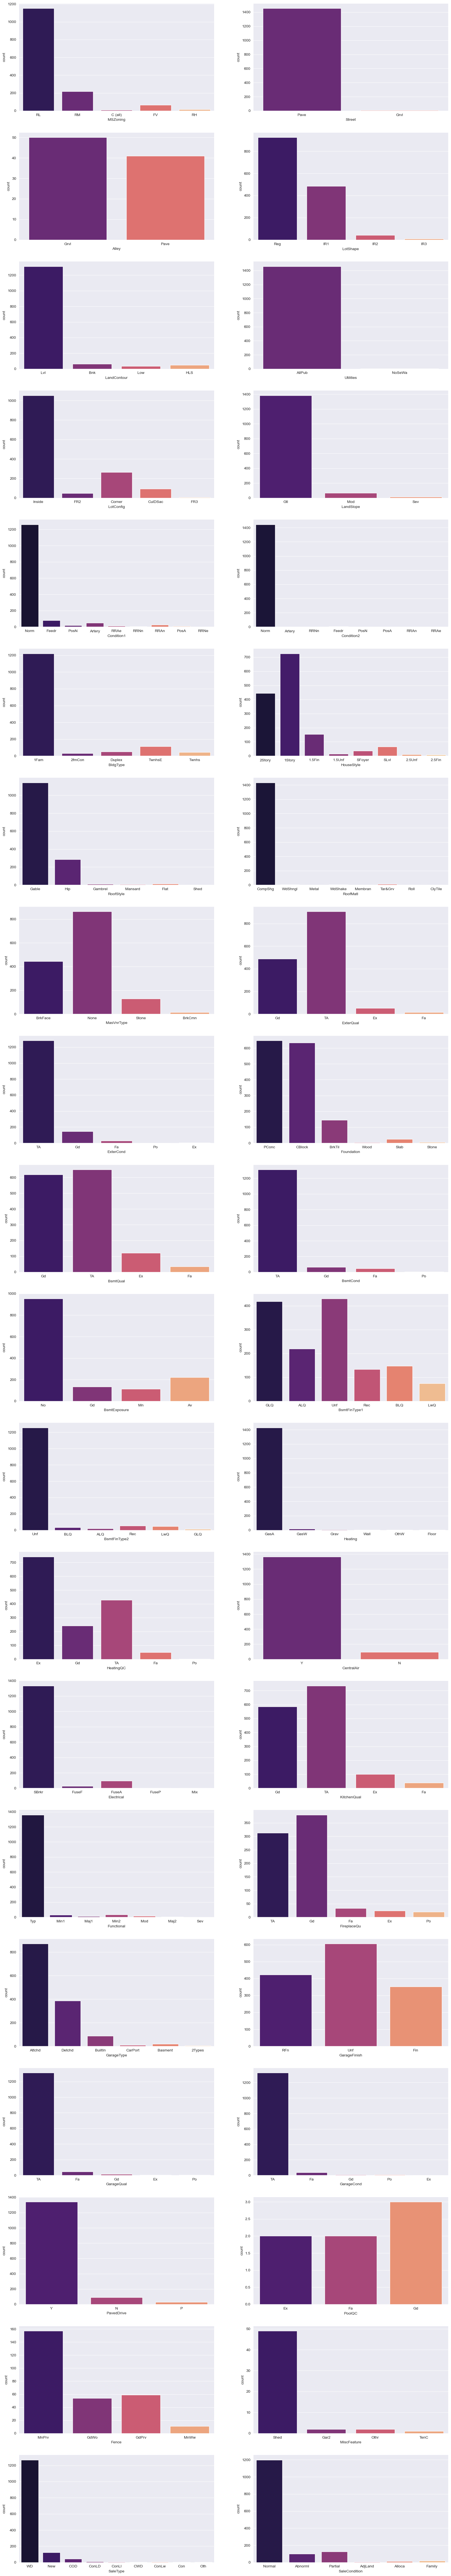

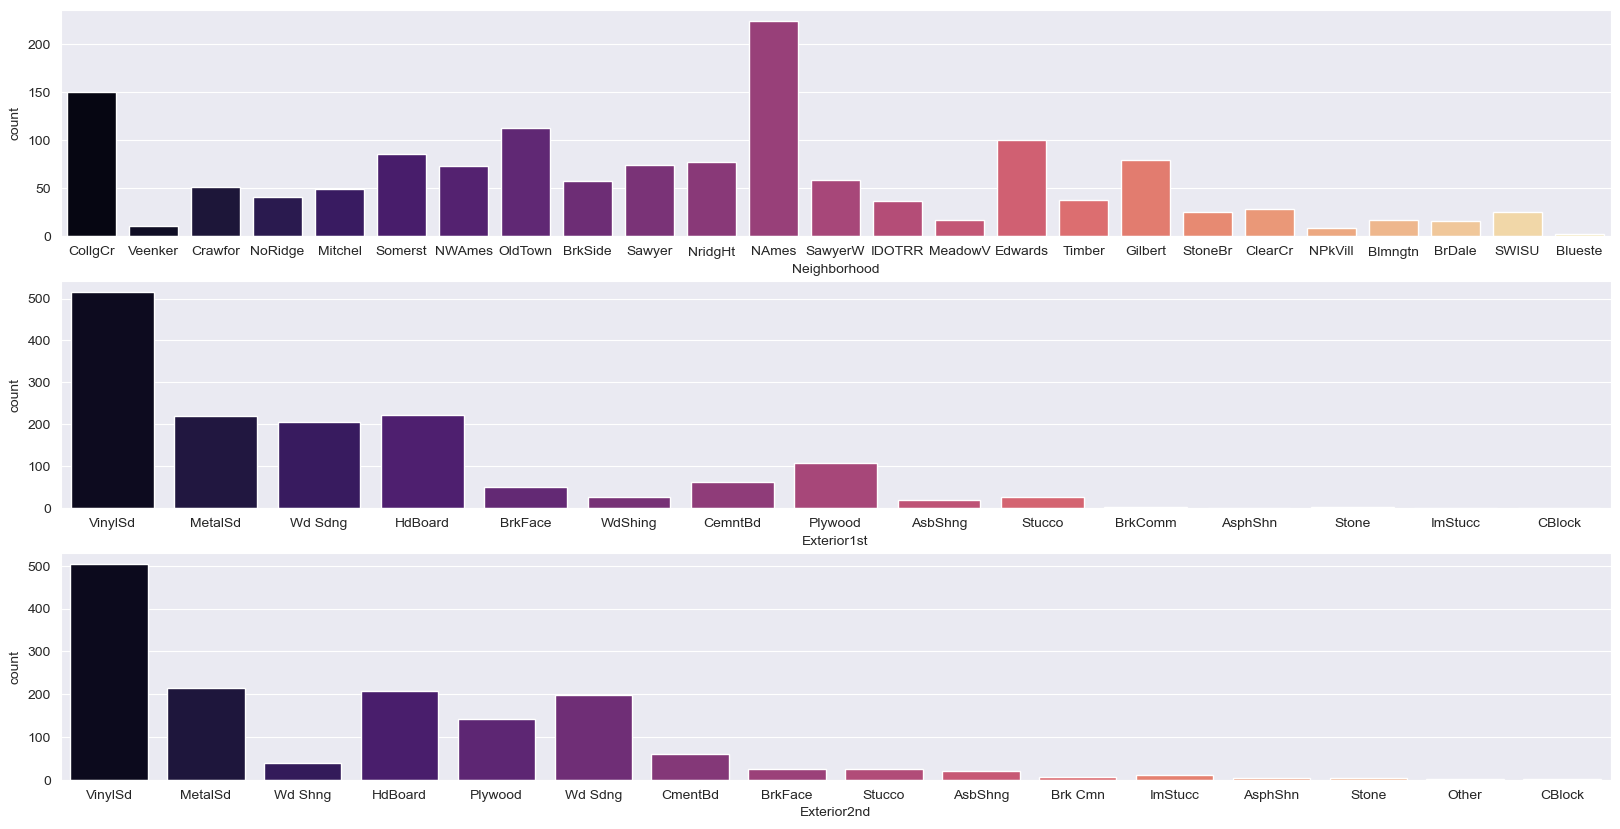

In [101]:
#To visualize the distribution of categories in all the categorical features we will use countplot
# we need to treet 3 features Neighbourhood, Exterior1st and Exterior2nd separately because of the large number of different categories as we can get that from the above dataframe
n_row=20
n_col=2
features_1=['Neighborhood','Exterior1st','Exterior2nd']
features_2=[feature for feature in categorical_features if feature not in features_1]

fig,ax=plt.subplots(nrows=20,ncols=2,figsize=(20,6*n_row))
i=0  #for row number
for feature in features_2:
    n=i//n_col   #for row no.
    m=i%n_col    #for col no.
    sns.countplot(x=feature,data=train,palette='magma',ax=ax[n,m])
    i+=1

#for plots in features_2
fig=plt.figure(figsize=(20,10))
ax=[None for _ in range(3)]
ax[0]=plt.subplot2grid((3,1),(0,0))
ax[1]=plt.subplot2grid((3,1),(1,0))
ax[2]=plt.subplot2grid((3,1),(2,0))
sns.countplot(x='Neighborhood',data=train,palette='magma',ax=ax[0])
sns.countplot(x='Exterior1st',data=train,palette='magma',ax=ax[1])
sns.countplot(x='Exterior2nd',data=train,palette='magma',ax=ax[2])

<Axes: xlabel='Exterior2nd', ylabel='SalePrice'>

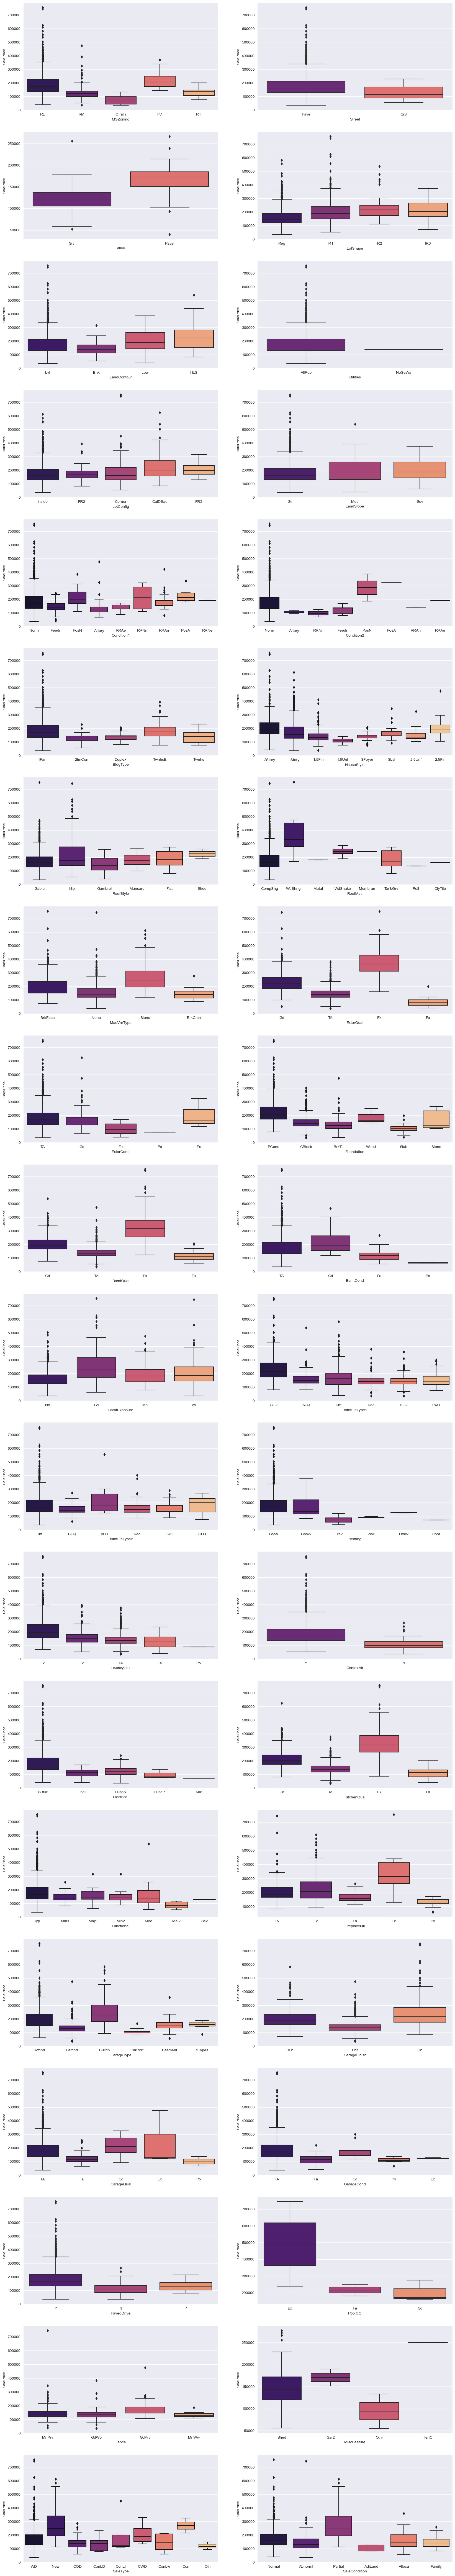

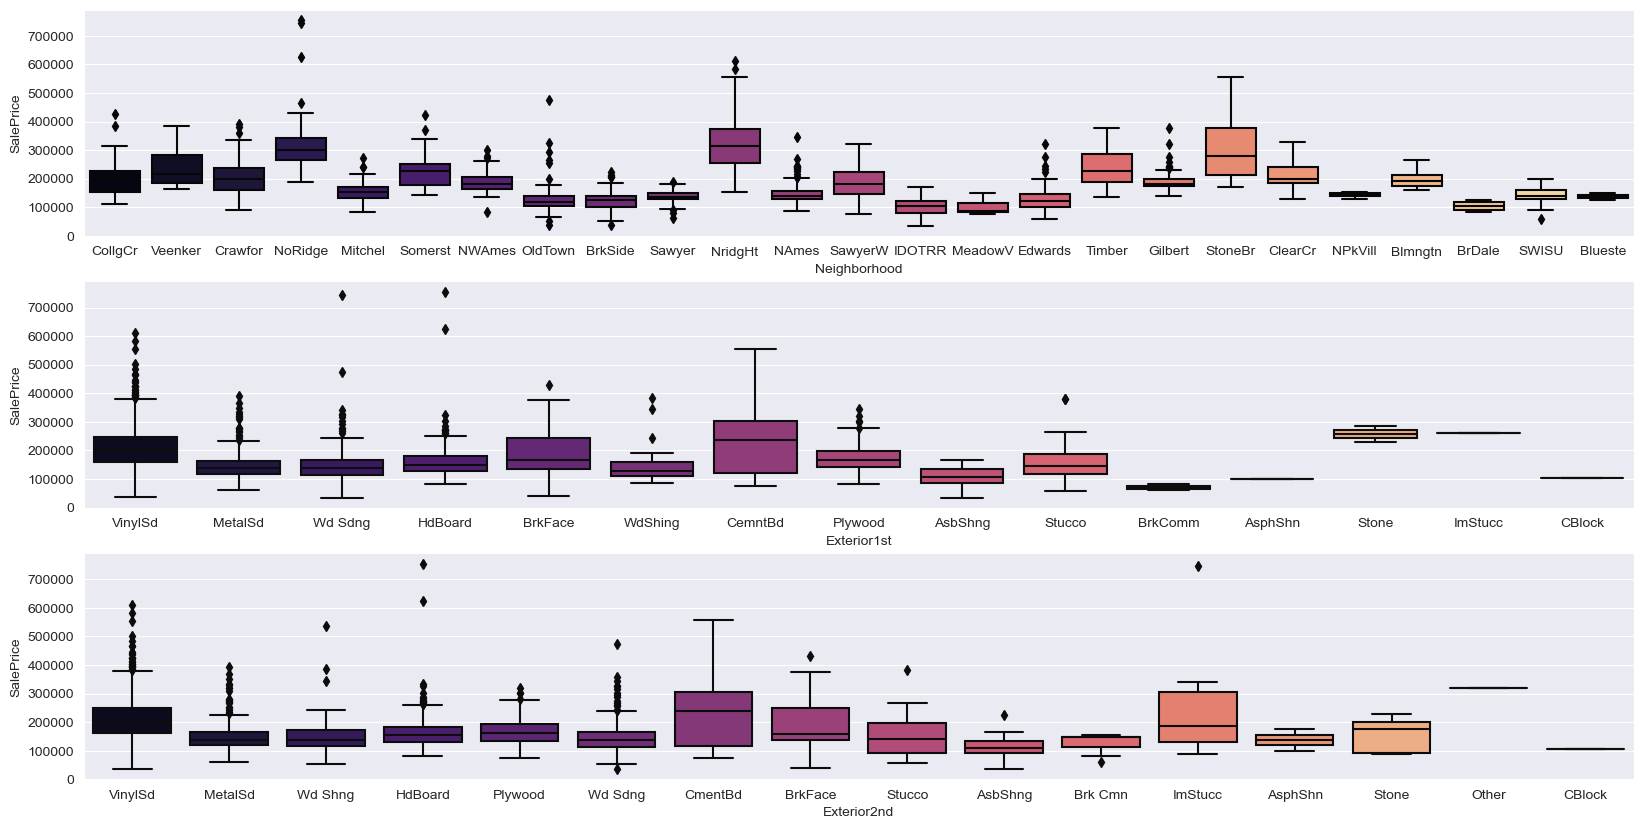

In [102]:
#To visualize correlation of different categorical features with the SalePrice
#we will make few changes to the above cell and will use box plot for this purpose
# we need to treet 3 features Neighbourhood, Exterior1st and Exterior2nd separately because of the large number of different categories as we can get that from the above dataframe
n_row=20
n_col=2
features_1=['Neighborhood','Exterior1st','Exterior2nd']
features_2=[feature for feature in categorical_features if feature not in features_1]

fig,ax=plt.subplots(nrows=20,ncols=2,figsize=(20,6*n_row))
i=0  #for row number
for feature in features_2:
    n=i//n_col   #for row no.
    m=i%n_col    #for col no.
    sns.boxplot(x=feature,y='SalePrice',data=train,palette='magma',ax=ax[n,m])
    i+=1

#for plots in features_2
fig=plt.figure(figsize=(20,10))
ax=[None for _ in range(3)]
ax[0]=plt.subplot2grid((3,1),(0,0))
ax[1]=plt.subplot2grid((3,1),(1,0))
ax[2]=plt.subplot2grid((3,1),(2,0))
sns.boxplot(x='Neighborhood',y='SalePrice',data=train,palette='magma',ax=ax[0])
sns.boxplot(x='Exterior1st',y='SalePrice',data=train,palette='magma',ax=ax[1])
sns.boxplot(x='Exterior2nd',y='SalePrice',data=train,palette='magma',ax=ax[2])

- Observations from the above set of countplots and boxplots:
- Street has two categories 'Pave':Paved and 'Grvl':Gravel, and only 6 observations are for Gravel type street.
- Alley has two categories "Pave" and "Grvl" and in total there are 91 observations from both categories.And houses with paved type alley access is higher as it should be but there are also some outliers in Grvl type .And it's been mentioned in the data description that Null values correspond to No alley access.
- Utilities has two categories as in the data and only 1 belongs to NoSeWa. Although in test set all the data points in 'Utilities' are AllPub
- Condition2 has 8 categories in total but category norm in alone has 1445 data points.And we can remove this category because from my understanding keeping both feture 'Category1' and 'Category2' will lead to multicollinearity.
- RoofMatl has in total 8 categories but 1434 data points are from 'CompShg' and houses where roofmatl is 'WdShngl' are expensive and there are also some extreme outliers in this category.
- Fence has total of 288 non-null values of which 157 belongs to MnPrv and it's given in the data description that null values correponds to No fence
- We will deal with the outliers and if required dive more in to the categories at the time of data preprocessing

In [103]:
#for numerical features
train_=train.copy()

In [104]:
#dropping the numerical features having high correlation among themselves as mentioned above and ofcourse ID column
train_.drop(['Id','GarageArea','TotalBsmtSF','TotRmsAbvGrd','GarageYrBlt'],axis=1,inplace=True)

In [105]:
#separating numerical and categorical features
categorical_features=[feature for feature in train_.columns if train_[feature].dtype=='object']
numerical_features=[feature for feature in train_.columns if feature not in categorical_features]

In [106]:
df_num=train_[numerical_features]
df_cat=train_[categorical_features]

In [107]:
#checking for null values in numerical features
dict_={}
for feature in df_num.columns:
    dict_[feature]=((df_num[feature].isnull().sum())/len(df_num))*100
pd.DataFrame(dict_,index=['%age null']).transpose()

,%age null
MSSubClass,0.000000
LotFrontage,17.739726
LotArea,0.000000
OverallQual,0.000000
OverallCond,0.000000
YearBuilt,0.000000
YearRemodAdd,0.000000
MasVnrArea,0.547945
BsmtFinSF1,0.000000
BsmtFinSF2,0.000000


In numerical features we have only two features with null values,Lotfrontage and MasVntArea, and in LotFrontage there are few outliers and there assuming there are genuine missing values we will impute it using median value for that feature and MasVnrArea it's given in the data description that None means there isn't any therefore we will simply impute it with zeros

In [108]:
df_num['LotFrontage']=np.where(df_num['LotFrontage'].isnull()==True,df_num['LotFrontage'].median(),df_num['LotFrontage'])
df_num['MasVnrArea']=np.where(df_num['MasVnrArea'].isnull()==True,0,df_num['MasVnrArea'])

From the box plots of the numerical features we will analyse the features having extreme outliers

In [109]:
#LotFrontage
df_num[df_num['LotFrontage']>150][['LotFrontage','SalePrice']]

,LotFrontage,SalePrice
197,174.0,235000
231,174.0,403000
934,313.0,242000
1107,168.0,274725
1127,182.0,259000
1182,160.0,745000
1211,152.0,164000
1298,313.0,160000
1337,153.0,52500


In [110]:
df_num[df_num['LotArea']>100000][['LotArea','SalePrice','LotFrontage']]

,LotArea,SalePrice,LotFrontage
249,159000,277000,69.0
313,215245,375000,150.0
335,164660,228950,69.0
706,115149,302000,69.0


From above two tables for lotArea it's completely justifiable to have the highest value which is 215245 since SalePrice and LotFrontage is also high for them but in case of LotFrontage it would be appropriate to remove the extreme outliers i.e., the values equal to 313

In [111]:
df_num[df_num['BsmtFinSF1']>2000]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
523,60,130.0,40094,10,5,2007,2008,762.0,2260,0,...,208,406,0,0,0,0,0,10,2007,184750
898,20,100.0,12919,9,5,2009,2010,760.0,2188,0,...,0,67,0,0,0,0,0,3,2010,611657
1182,60,160.0,15623,10,5,1996,1996,0.0,2096,0,...,171,78,0,0,0,555,0,7,2007,745000
1298,60,313.0,63887,10,5,2008,2008,796.0,5644,0,...,214,292,0,0,0,480,0,1,2008,160000


In [112]:
df_num[df_num['1stFlrSF']>3000]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
496,20,69.0,12692,8,5,1992,1993,0.0,1231,0,...,264,75,291,0,0,0,0,5,2007,430000
523,60,130.0,40094,10,5,2007,2008,762.0,2260,0,...,208,406,0,0,0,0,0,10,2007,184750
1298,60,313.0,63887,10,5,2008,2008,796.0,5644,0,...,214,292,0,0,0,480,0,1,2008,160000


In [113]:
df_num[df_num['SalePrice']>700000]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
691,60,104.0,21535,10,6,1994,1995,1170.0,1455,0,...,382,50,0,0,0,0,0,1,2007,755000
1182,60,160.0,15623,10,5,1996,1996,0.0,2096,0,...,171,78,0,0,0,555,0,7,2007,745000


we just need to remove the rows having LotFrontage==313, and subsequentily the exteme outliers in 'BsmtFinSF1 and in 1stFlrSf will be removed and we will remove houses with SalePrice>7000000

In [114]:
idx_1=df_num[df_num['LotFrontage']==313].index
idx_2=df_num[df_num['SalePrice']>700000].index

In [115]:
#we need to drop the following rows from both numerical dataframe df_num and categorical dataframe df_cat
df_num.drop(idx_1,inplace=True)
df_num.drop(idx_2,inplace=True)
df_num.reset_index(drop=True,inplace=True)

df_cat.drop(idx_1,inplace=True)
df_cat.drop(idx_2,inplace=True)
df_cat.reset_index(drop=True,inplace=True)

when we observe test test there are lot of numerical features that contain that has null values, therefore we will use the skleran imputer with median strategy to impute on the test set


In [116]:
#we will first separate the target variable and independent variables separately
X=df_num.drop('SalePrice',axis=1)
y=df_num['SalePrice']
imputer_num=SimpleImputer(strategy='median')
X_=pd.DataFrame(imputer_num.fit_transform(X),columns=X.columns)

In [117]:
scaler_=StandardScaler()
X_=pd.DataFrame(scaler_.fit_transform(X_),columns=X_.columns)

Now we are done witht the numerical features and will move to the categorical features

In [118]:
#null values in categorical features
dict_={}
for feature in df_cat.columns:
    dict_[feature]=((df_cat[feature].isnull().sum())/len(df_cat))*100
pd.DataFrame(dict_,index=['%age null']).transpose()

,%age null
MSZoning,0.000000
Street,0.000000
Alley,93.750000
LotShape,0.000000
LandContour,0.000000
Utilities,0.000000
LotConfig,0.000000
LandSlope,0.000000
Neighborhood,0.000000
Condition1,0.000000


For 'POOLQC' which has more than 99% of missing values and from the countplot and boxplot, although where PoolQC is Excellent the House is expensice but there is only two entries in that particular category and there are also many outliers in the 'SalePrice' of houses with no Pool , therefore i'm gonna drop it

In [119]:
df_cat.drop('PoolQC',axis=1,inplace=True)

For MiscFeature, it has about 96% of missing value but again from the description it is mentioned that null vaues represent no MiscFeature, and from the countplot and boxplot there are few (about 50)values that belongs to shed category, for now i'm just going to replace the missing values with No_Misc

Feature 'Heating' has around 1400+ entries in GasA type category, therefore it's better to remove it, anyways we have HeatingQC feature.

In [120]:
df_cat.drop(['Heating'],axis=1,inplace=True)

In [121]:
df_cat['MiscFeature']=np.where(df_cat['MiscFeature'].isnull()==True,'No_misc',df_cat['MiscFeature'])

For alley,fence,MasVnrType and FireplaceQu null value represents, that particular feature is not there therefore we will replace the null values accordingly

In [122]:
df_cat['Alley']=np.where(df_cat['Alley'].isnull()==True,'No_alley',df_cat['Alley'])
df_cat['Fence']=np.where(df_cat['Fence'].isnull()==True,'No_fence',df_cat['Fence'])
df_cat['MasVnrType']=np.where(df_cat['MasVnrType'].isnull()==True,'No_venner',df_cat['MasVnrType'])
df_cat['FireplaceQu']=np.where(df_cat['FireplaceQu'].isnull()==True,'No_fireplace',df_cat['FireplaceQu'])

For GarageType,GarageFinish,GarageQual and GarageCond, in all of these null values represents there isn't a garage.

GarageQual and GarageCond are i believe somewhat same thing and even the distributions are kind of same as we observe from the countplot, therefore we will drop GarageCond and in other three we will replace the null values with 'No_garage'

In [123]:
df_cat.drop('GarageCond',axis=1,inplace=True)
df_cat['GarageType']=np.where(df_cat['GarageType'].isnull()==True,'No_garage',df_cat['GarageType'])
df_cat['GarageFinish']=np.where(df_cat['GarageFinish'].isnull()==True,'No_garage',df_cat['GarageFinish'])
df_cat['GarageQual']=np.where(df_cat['GarageQual'].isnull()==True,'No_garage',df_cat['GarageQual'])

From basementQual,BsmtCond,BsmtFinType1 ,BsmtFinType2 and BsmtExposure we will drop BsmtCond and BsmtFinType2, there is no particular reason it's just the distribution from the count plot

In [124]:
df_cat.drop(['BsmtCond','BsmtFinType2'],axis=1,inplace=True)
df_cat['BsmtQual']=np.where(df_cat['BsmtQual'].isnull()==True,'no_bsmt',df_cat['BsmtQual'])
df_cat['BsmtFinType1']=np.where(df_cat['BsmtFinType1'].isnull()==True,'no_bsmt',df_cat['BsmtFinType1'])
df_cat['BsmtExposure']=np.where(df_cat['BsmtExposure'].isnull()==True,'no_bsmt',df_cat['BsmtExposure'])

For electrical, we will just impute it with the mode value.

In [125]:
df_cat['Electrical']=np.where(df_cat['Electrical'].isnull()==True,df_cat['Electrical'].mode()[0],df_cat['Electrical'])

We will also create a imputer class just like we did it for numerical_features like if there are any other null values other than described above we will use it

In [126]:
imputer_cat=SimpleImputer(strategy='most_frequent')
df_cat_=pd.DataFrame(imputer_cat.fit_transform(df_cat),columns=df_cat.columns)

Now that we are done with the imputing we'll proceed to the encoding part and if we look at the categorical features it's obvious that some of the features are ordinal and some should be treated nominal. And will try to separate them and treat them accordingly

In [127]:
ordinal_features=['ExterQual','ExterCond','BsmtQual','BsmtExposure','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageFinish','CentralAir']
nominal_features=[feature for feature in df_cat.columns if feature not in ordinal_features]

In [128]:
df_cat_['ExterQual']=df_cat_['ExterQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_cat_['ExterCond']=df_cat_['ExterCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_cat_['BsmtQual']=df_cat_['BsmtQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'no_bsmt':0})
df_cat_['BsmtExposure']=df_cat_['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'no_bsmt':0})
df_cat_['HeatingQC']=df_cat_['HeatingQC'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_cat_['KitchenQual']=df_cat_['KitchenQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
df_cat_['FireplaceQu']=df_cat_['FireplaceQu'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No_fireplace':0})
df_cat_['GarageQual']=df_cat_['GarageQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No_garage':0})
df_cat_['GarageFinish']=df_cat_['GarageFinish'].map({'Fin':3,'RFn':2,'Unf':1,'No_garage':0})
df_cat_['CentralAir']=df_cat_['CentralAir'].map({'Y':1,'N':0})

In [129]:
df_cat_nominal=df_cat_[nominal_features]
df_cat_ordinal=df_cat_[ordinal_features]

In [130]:
df_cat_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ExterQual     1456 non-null   int64
 1   ExterCond     1456 non-null   int64
 2   BsmtQual      1456 non-null   int64
 3   BsmtExposure  1456 non-null   int64
 4   HeatingQC     1456 non-null   int64
 5   KitchenQual   1456 non-null   int64
 6   FireplaceQu   1456 non-null   int64
 7   GarageQual    1456 non-null   int64
 8   GarageFinish  1456 non-null   int64
 9   CentralAir    1456 non-null   int64
dtypes: int64(10)
memory usage: 113.9 KB


In [131]:
# we will use one hot encoding technique for nominal features
encoder_=OneHotEncoder(handle_unknown='ignore')
df_cat_nominal=pd.DataFrame(encoder_.fit_transform(df_cat_nominal).toarray())

I am planning to train the data on RandomForest,xgboost and catboost and since for catboost we will need categorical features therefore i will concatenate all the features in two different ways

In [132]:
train_data=pd.concat([X_,df_cat_ordinal,df_cat_nominal],axis=1)

In [153]:
#splitting the dataset
X_train_,X_val_,y_train_,y_val_=train_test_split(train_data,y,test_size=0.2,random_state=42)
X_train_=X_train_.to_numpy()
y_train_=y_train_.to_numpy()
X_val_=X_val_.to_numpy()
y_val_=y_val_.to_numpy()

In [148]:
forest=RandomForestRegressor()

n_estimators=[int(x) for x in np.linspace(2,100,50)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(2,50,10)]
min_samples_split=[1,2,3,4,5]
min_samples_leaf=[1,2,3,4,5]
bootstrap=[True,False]
#defining the parameter grid space

parameter_grid_forest={     
    'n_estimators':n_estimators,
    'max_features':max_features,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
}

grid_search=RandomizedSearchCV(estimator=forest,param_distributions=parameter_grid_forest,n_iter=20,cv=5,scoring='neg_mean_squared_error',random_state=42,verbose=True)

In [149]:
grid_search.fit(X_train_,y_train_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [1, 2, 3, 4, 5],
                                        'n_estimators': [2, 4, 6, 8, 10, 12, 14,
                                                         16, 18, 20, 22, 24, 26,
                                                         28, 30, 32, 34, 36, 38,
                                                         40, 42, 44, 46, 48, 50,
                                                         52, 54, 56, 58, 60, ...]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=True)

In [150]:
model=grid_search.best_estimator_

In [151]:
model.fit(X_train_,y_train_)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=3, n_estimators=36)

In [154]:
y_pred=model.predict(X_val_)

In [155]:
np.sqrt(mean_squared_error(y_val_,y_pred))

22662.919407310572

In [156]:
xgb=XGBRegressor()

#parameter grid
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05]
min_child_weight=[1,2,3,4]
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster
    }
grid_=RandomizedSearchCV(estimator=xgb,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            random_state=42)


In [157]:
grid_.fit(X_train_,y_train_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END booster=gbtree, learning_rate=0.005, max_depth=3, min_child_weight=2, n_estimators=500;, score=-20853.739 total time=   2.5s
[CV 2/5] END booster=gbtree, learning_rate=0.005, max_depth=3, min_child_weight=2, n_estimators=500;, score=-23671.615 total time=   2.5s
[CV 3/5] END booster=gbtree, learning_rate=0.005, max_depth=3, min_child_weight=2, n_estimators=500;, score=-25434.974 total time=   2.5s
[CV 4/5] END booster=gbtree, learning_rate=0.005, max_depth=3, min_child_weight=2, n_estimators=500;, score=-23372.799 total time=   2.5s
[CV 5/5] END booster=gbtree, learning_rate=0.005, max_depth=3, min_child_weight=2, n_estimators=500;, score=-24485.470 total time=   2.8s
[CV 3/5] END booster=gbtree, learning_rate=0.0005, max_depth=5, min_child_weight=3, n_estimators=1500;, score=-88444.751 total time=  14.7s
[CV 1/5] END booster=gbtree, learning_rate=0.0005, max_depth=5, min_child_weight=3, n_estimators=1500;, scor

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=4,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [1e-05, 5e-05, 0.0001,
                                                          0.0005, 0.001, 0.005,
                                                          0.01, 0.05],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=5)

In [158]:
model=grid_.best_estimator_

In [159]:
model.fit(X_train_,y_train_)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [160]:
y_pred=model.predict(X_val_)

In [161]:
np.sqrt(mean_squared_error(y_val_,y_pred))

20625.49744278286

In [162]:
models = pd.DataFrame({
    'Model' : ['RandomForest Regressor','XGB Regressor'],
    'rms_Score' : [23890.54,20648.60]
})

In [163]:
px.bar(data_frame = models, x = 'rms_Score', y = 'Model', color = 'rms_Score', template = 'plotly_dark', title = 'Models Comparison')